# CGANs - Conditional Generative Adversarial Nets

Introduction to Conditional Generative Adversarial Nets or CGANs.

This notebook is organized follows:

1. **Background**
* **Definition**
* **Training CGANs with CIFAR-10 dataset, Keras and TensorFlow**


## 1. Background

**Generative adversarial nets** consists of two models: a generative model $G$ that captures the data distribution, and a discriminative model $D$ that estimates the probability that a sample came from the training data rather than $G$.

The generator distribution $p_g$ over data data $x$, the generator builds a mapping function from a prior noise distribution $p_z(z)$ to data space as $G(z;\theta_g)$.

The discriminator, $D(x;\theta_d)$, outputs a single scalar representing the probability that $x$ came form training data rather than $p_g$.

The value function $V(G,D)$:

$$ \underset{G}{min} \: \underset{D}{max} \; V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$


## 2. Definition

Generative adversarial nets can be extended to a **conditional model** if both the generator and discriminator are conditioned on some extra information $y$. 

* $y$ could be any kind of auxiliary information, such as class labels or data from other modalities. 

We can perform the conditioning by feeding $y$ into the both the discriminator and generator as additional input layer.

### Generator

The prior input noise $p_z(z)$, and $y$ are combined in joint hidden representation, and the adversarial training framework allows for considerable flexibility in how this hidden representation is composed.

### Discriminator

$x$ and $y$ are presented as inputs and to a discriminative function.

### Value function

$$ \underset{G}{min} \: \underset{D}{max} \; V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x|y)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z|y)))]$$

### Structure

![cgan](../../img/cgan.png)

## 3. Training CGANs with CIFAR-10 dataset, Keras and TensorFlow

A CGANs implementation using the transposed convolution and convolution neural network, concatenate layers and the [Keras](https://keras.io/) library.

### 1. Load data

#### Load libraries

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.layers import Input, Flatten, Embedding, multiply, Dropout
from keras.layers import Concatenate, GaussianNoise,Activation
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical
from keras import initializers
from keras import backend as K

Using TensorFlow backend.


#### Getting the data

In [3]:

# cached images
# cached_images = '/Volumes/Samsung_T3/bathy_training/cache_images_ohara_07.npz'
cached_images = '/data/bathy_training/cache_images_ohara_07.npz'

# cached bathymetry 
#cached_bpatches = '/Volumes/Samsung_T3/bathy_training/cache_bpatches_ohara_07.npz'
cached_bpatches = '/data/bathy_training/cache_bpatches_ohara_07.npz'

# load dataset
data =  np.load(cached_images)
Ximg_train = data['xtrain']
data = np.load(cached_bpatches)
Xbathy_train = data['xtrain']




#### Explore visual data

The images are AUV thumbnails and bathy is a corresponding patch around image location

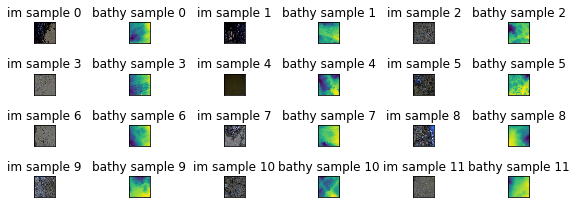

In [4]:
num_samples = 12
fig = plt.figure(figsize=(8,3))
for i in range(num_samples):
    ax = plt.subplot(4, 6, 1 + 2*i, xticks=[], yticks=[])
    img_num = np.random.randint(Ximg_train.shape[0])
    img = Ximg_train[img_num,::]
    ax.set_title("im sample " + str(i))
    plt.imshow(img)
    
    bpatch = Xbathy_train[img_num,:,:,0]
    ax = plt.subplot(4, 6, 1 + 2*i+1, xticks=[], yticks=[])
    ax.set_title("bathy sample " + str(i))
    plt.imshow(bpatch)
    
    
plt.tight_layout()

#### Reshaping and normalizing the inputs

In [5]:
print('Ximg_train shape:', Ximg_train.shape)
print('Xbathy_train shape:', Xbathy_train.shape)
print(Ximg_train.shape[0], 'train img samples')
print(Xbathy_train.shape[0], 'train bathy samples')

Ximg_train shape: (11278, 64, 64, 3)
Xbathy_train shape: (11278, 21, 21, 1)
11278 train img samples
11278 train bathy samples


In [6]:
##if K.image_data_format() == 'channels_first':
##    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
##    X_test = X_test.reshape(X_test.shape[0], 3, 32, 32)
##    input_shape = (3, 32, 32)
##else:
##    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
##    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
##    input_shape = (32, 32, 3)
    
### convert class vectors to binary class matrices
##Y_train = np_utils.to_categorical(y_train, num_classes)
##Y_test = np_utils.to_categorical(y_test, num_classes)

### the generator is using tanh activation, for which we need to preprocess 
### the image data into the range between -1 and 1.

##X_train = np.float32(X_train)
##X_train = (X_train / 255 - 0.5) * 2
##X_train = np.clip(X_train, -1, 1)

##X_test = np.float32(X_test)
##X_test = (X_test / 255 - 0.5) * 2
##X_test = np.clip(X_test, -1, 1)

##print('X_train reshape:', X_train.shape)
##print('X_test reshape:', X_test.shape)

In [7]:
print(Ximg_train[0].shape)

(64, 64, 3)


### 2. Define model

#### Generator

In [8]:
# latent space dimension
z = Input(shape=(100,))

# bathy
bpatch = Input(shape=Xbathy_train[0].shape)
bvec = Flatten()(bpatch)

# Generator network
merged_layer = Concatenate()([z, bvec])

# FC: 2x2x512
generator = Dense(2*2*512, activation='relu')(merged_layer)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)
generator = Reshape((2, 2, 512))(generator)

# # Conv 1: 4x4x256
generator = Conv2DTranspose(256, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

# Conv 2: 8x8x128
generator = Conv2DTranspose(128, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

# Conv 3: 16x16x64
generator = Conv2DTranspose(64, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)


# Conv 4: 32x32x32
generator = Conv2DTranspose(32, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

# Conv 5: 64x64x3
generator = Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh')(generator)

# generator = Model(inputs=[z, labels], outputs=out_g)
generator = Model(inputs=[z, bpatch], outputs=generator, name='generator')

#### Generator model visualization

In [9]:
# prints a summary representation of your model
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 21, 21, 1)    0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 441)          0           input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 541)          0           input_1[0][0]                    
                                                                 flatten_1[0][0]                  
__________

#### Discriminator

In [10]:
# input image
img_input = Input(shape=(Ximg_train[0].shape))

# bathy conditioning
bpatch = Input(shape=Xbathy_train[0].shape)
bvec = Flatten()(bpatch)

# Conv 1: 16x16x64
discriminator = Conv2D(64, kernel_size=5, strides=2, padding='same')(img_input)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# Conv 2:
discriminator = Conv2D(128, kernel_size=5, strides=2, padding='same')(discriminator)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# Conv 3: 
discriminator = Conv2D(256, kernel_size=5, strides=2, padding='same')(discriminator)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# Conv 4: 
discriminator = Conv2D(512, kernel_size=5, strides=2, padding='same')(discriminator)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# FC
discriminator = Flatten()(discriminator)

# Concatenate 
merged_layer = Concatenate()([discriminator, bvec])
discriminator = Dense(512, activation='relu')(merged_layer)
    
# Output
discriminator = Dense(1, activation='sigmoid')(discriminator)

discriminator = Model(inputs=[img_input, bpatch], outputs=discriminator, name='discriminator')

#### Discriminator model visualization

In [11]:
# prints a summary representation of your model
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   4864        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 32, 32, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_6 (LeakyReLU)       (None, 32, 32, 64)   0           batch_normalization_6[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

### 3. Compile model

#### Compile discriminator

In [12]:
# # Optimizer
discriminator.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

#### Combined network

In [26]:
discriminator.trainable = False

bpatch = Input(shape=Xbathy_train[0].shape, name='bpatch')
z = Input(shape=(100,), name='z')

fake_img = generator([z, bpatch])
validity = discriminator([fake_img, bpatch])

d_g = Model([z, bpatch], validity, name='adversarial')

d_g.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy',
            metrics=['binary_accuracy'])
#d_g.compile(Adam(lr=0.0004, beta_1=0.5), loss='binary_crossentropy',
        #    metrics=['binary_accuracy'])

In [27]:
# prints a summary representation of your model
d_g.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z (InputLayer)                  (None, 100)          0                                            
__________________________________________________________________________________________________
bpatch (InputLayer)             (None, 21, 21, 1)    0                                            
__________________________________________________________________________________________________
generator (Model)               (None, 64, 64, 3)    5475011     z[0][0]                          
                                                                 bpatch[0][0]                     
__________________________________________________________________________________________________
discriminator (Model)           (None, 1)            8731521     generator[2][0]                  
          

### 4. Fit model


epoch = 1/1000, d_loss=0.163, g_loss=16.118                                                                                                                      


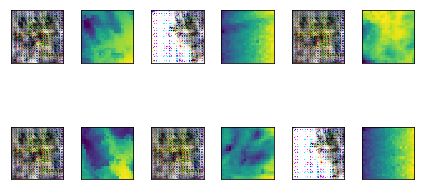

epoch = 2/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 3/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 4/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 5/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 6/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 7/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 8/1000, d_loss=0.163

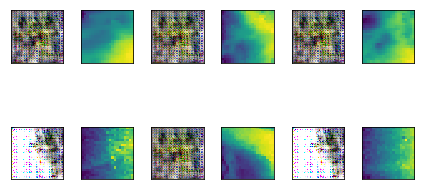

epoch = 12/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 13/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 14/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 15/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 16/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 17/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 18/1000, d_los

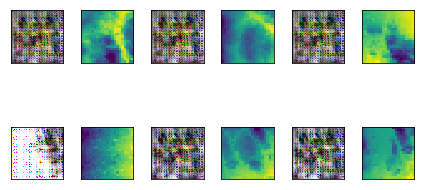

epoch = 22/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 23/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 24/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 25/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 26/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 27/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 28/1000, d_los

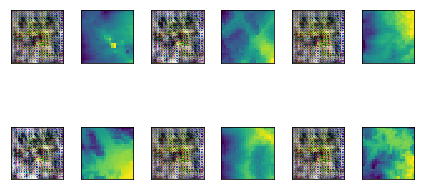

epoch = 32/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 33/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 34/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 35/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 36/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 37/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 38/1000, d_los

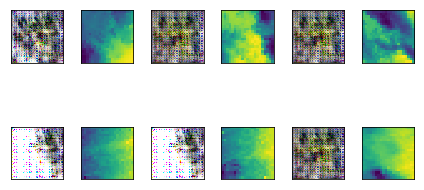

epoch = 42/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 43/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 44/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 45/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 46/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 47/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 48/1000, d_los

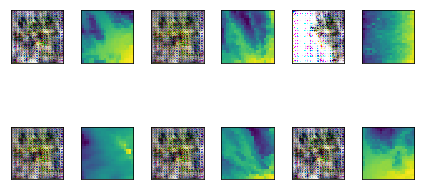

epoch = 52/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 53/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 54/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 55/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 56/1000, d_loss=0.163, g_loss=0.090                                                                                                                      
epoch = 57/1000, d_loss=0.163, g_loss=0.085                                                                                                                      
epoch = 58/1000, d_loss=

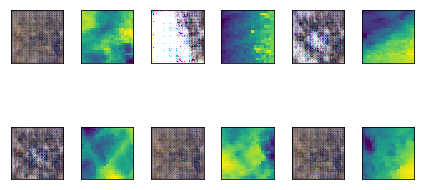

epoch = 62/1000, d_loss=0.163, g_loss=0.073                                                                                                                      
epoch = 63/1000, d_loss=0.163, g_loss=0.070                                                                                                                      
epoch = 64/1000, d_loss=0.163, g_loss=0.070                                                                                                                      
epoch = 65/1000, d_loss=0.163, g_loss=0.066                                                                                                                      
epoch = 66/1000, d_loss=0.163, g_loss=0.066                                                                                                                      
epoch = 67/1000, d_loss=0.163, g_loss=0.067                                                                                                                      
epoch = 68/1000, d_loss=0.16

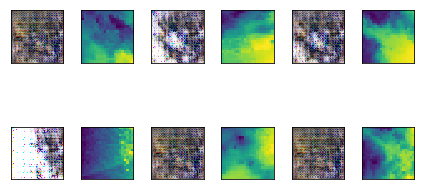

epoch = 72/1000, d_loss=0.163, g_loss=0.062                                                                                                                      
epoch = 73/1000, d_loss=0.163, g_loss=0.079                                                                                                                       
epoch = 74/1000, d_loss=0.163, g_loss=0.070                                                                                                                      
epoch = 75/1000, d_loss=0.163, g_loss=0.064                                                                                                                      
epoch = 76/1000, d_loss=0.163, g_loss=0.060                                                                                                                      
epoch = 77/1000, d_loss=0.163, g_loss=0.060                                                                                                                      
epoch = 78/1000, d_loss=0.1

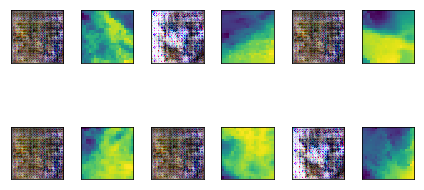

epoch = 82/1000, d_loss=0.163, g_loss=0.075                                                                                                                      
epoch = 83/1000, d_loss=0.163, g_loss=0.067                                                                                                                      
epoch = 84/1000, d_loss=0.163, g_loss=0.064                                                                                                                      
epoch = 85/1000, d_loss=0.163, g_loss=0.063                                                                                                                      
epoch = 86/1000, d_loss=0.163, g_loss=0.060                                                                                                                      
epoch = 87/1000, d_loss=0.163, g_loss=0.061                                                                                                                      
epoch = 88/1000, d_loss=0.16

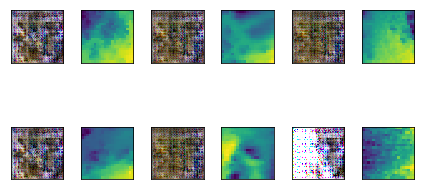

epoch = 92/1000, d_loss=0.163, g_loss=0.060                                                                                                                      
epoch = 93/1000, d_loss=0.163, g_loss=0.057                                                                                                                      
epoch = 94/1000, d_loss=0.163, g_loss=0.055                                                                                                                      
epoch = 95/1000, d_loss=0.163, g_loss=0.055                                                                                                                      
epoch = 96/1000, d_loss=0.163, g_loss=0.057                                                                                                                      
epoch = 97/1000, d_loss=0.163, g_loss=0.054                                                                                                                      
epoch = 98/1000, d_loss=0.16

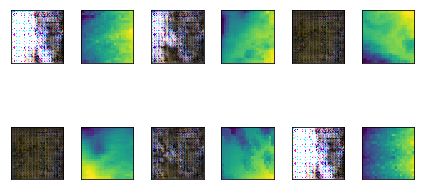

epoch = 102/1000, d_loss=0.163, g_loss=0.084                                                                                                                      
epoch = 103/1000, d_loss=0.163, g_loss=0.080                                                                                                                      
epoch = 104/1000, d_loss=0.163, g_loss=0.076                                                                                                                      
epoch = 105/1000, d_loss=0.163, g_loss=0.072                                                                                                                      
epoch = 106/1000, d_loss=0.163, g_loss=0.072                                                                                                                      
epoch = 107/1000, d_loss=0.163, g_loss=0.070                                                                                                                      
epoch = 108/1000, d_lo

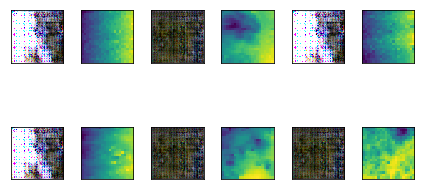

epoch = 112/1000, d_loss=0.163, g_loss=0.066                                                                                                                      
epoch = 113/1000, d_loss=0.163, g_loss=0.064                                                                                                                      
epoch = 114/1000, d_loss=0.163, g_loss=0.087                                                                                                                       
epoch = 115/1000, d_loss=0.163, g_loss=0.079                                                                                                                      
epoch = 116/1000, d_loss=0.163, g_loss=0.078                                                                                                                      
epoch = 117/1000, d_loss=0.163, g_loss=0.074                                                                                                                      
epoch = 118/1000, d_l

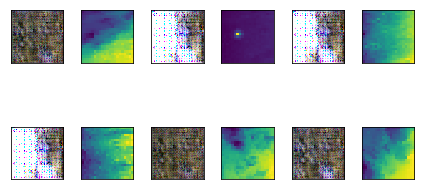

epoch = 122/1000, d_loss=0.163, g_loss=0.068                                                                                                                      
epoch = 123/1000, d_loss=0.163, g_loss=0.069                                                                                                                      
epoch = 124/1000, d_loss=0.163, g_loss=0.067                                                                                                                      
epoch = 125/1000, d_loss=0.163, g_loss=0.068                                                                                                                      
epoch = 126/1000, d_loss=0.163, g_loss=0.066                                                                                                                      
epoch = 127/1000, d_loss=0.163, g_loss=0.064                                                                                                                      
epoch = 128/1000, d_lo

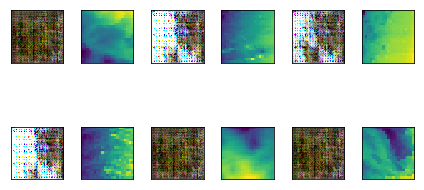

epoch = 132/1000, d_loss=0.163, g_loss=0.068                                                                                                                      
epoch = 133/1000, d_loss=0.163, g_loss=0.067                                                                                                                      
epoch = 134/1000, d_loss=0.163, g_loss=0.062                                                                                                                      
epoch = 135/1000, d_loss=0.163, g_loss=0.063                                                                                                                      
epoch = 136/1000, d_loss=0.163, g_loss=0.060                                                                                                                      
epoch = 137/1000, d_loss=0.163, g_loss=0.062                                                                                                                      
epoch = 138/1000, d_lo

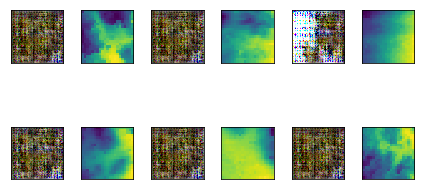

epoch = 142/1000, d_loss=0.163, g_loss=0.056                                                                                                                      
epoch = 143/1000, d_loss=0.163, g_loss=0.060                                                                                                                      
epoch = 144/1000, d_loss=0.163, g_loss=11.107                                                                                                                      
epoch = 145/1000, d_loss=0.163, g_loss=0.089                                                                                                                      
epoch = 146/1000, d_loss=0.163, g_loss=0.086                                                                                                                      
epoch = 147/1000, d_loss=0.163, g_loss=0.078                                                                                                                      
epoch = 148/1000, d_l

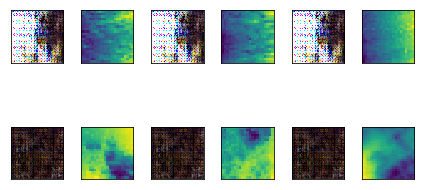

epoch = 152/1000, d_loss=0.163, g_loss=0.066                                                                                                                      
epoch = 153/1000, d_loss=0.163, g_loss=0.069                                                                                                                      
epoch = 154/1000, d_loss=0.163, g_loss=0.067                                                                                                                      
epoch = 155/1000, d_loss=0.163, g_loss=0.064                                                                                                                      
epoch = 156/1000, d_loss=0.163, g_loss=0.069                                                                                                                      
epoch = 157/1000, d_loss=0.163, g_loss=0.062                                                                                                                      
epoch = 158/1000, d_lo

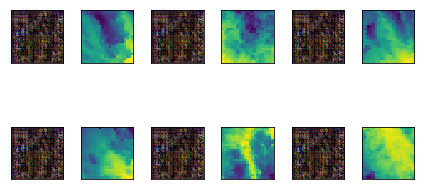

epoch = 162/1000, d_loss=0.163, g_loss=0.066                                                                                                                      
epoch = 163/1000, d_loss=0.163, g_loss=0.061                                                                                                                      
epoch = 164/1000, d_loss=0.163, g_loss=0.066                                                                                                                      
epoch = 165/1000, d_loss=0.163, g_loss=0.064                                                                                                                      
epoch = 166/1000, d_loss=0.163, g_loss=0.058                                                                                                                      
epoch = 167/1000, d_loss=0.163, g_loss=0.058                                                                                                                      
epoch = 168/1000, d_lo

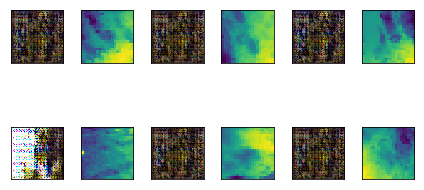

epoch = 172/1000, d_loss=0.163, g_loss=0.056                                                                                                                      
epoch = 173/1000, d_loss=0.163, g_loss=0.058                                                                                                                      
epoch = 174/1000, d_loss=0.163, g_loss=0.057                                                                                                                      
epoch = 175/1000, d_loss=0.163, g_loss=0.059                                                                                                                      
epoch = 176/1000, d_loss=0.163, g_loss=0.062                                                                                                                      
epoch = 177/1000, d_loss=0.163, g_loss=0.061                                                                                                                      
epoch = 178/1000, d_lo

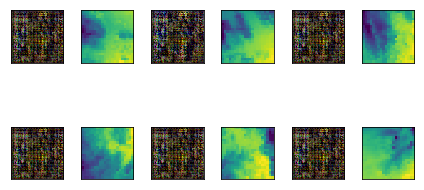

epoch = 182/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 183/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 184/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 185/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 186/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 187/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 188/1000

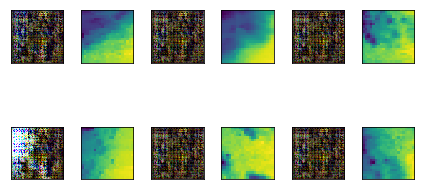

epoch = 192/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 193/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 194/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 195/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 196/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 197/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 198/1000

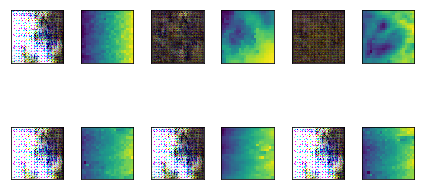

epoch = 202/1000, d_loss=0.163, g_loss=0.083                                                                                                                      
epoch = 203/1000, d_loss=0.163, g_loss=0.080                                                                                                                      
epoch = 204/1000, d_loss=0.163, g_loss=0.078                                                                                                                      
epoch = 205/1000, d_loss=0.163, g_loss=0.078                                                                                                                      
epoch = 206/1000, d_loss=0.163, g_loss=0.078                                                                                                                      
epoch = 207/1000, d_loss=0.163, g_loss=0.077                                                                                                                      
epoch = 208/1000, d_lo

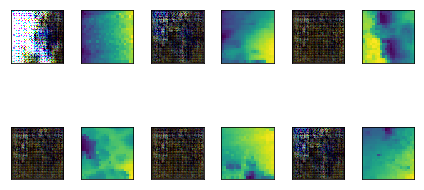

epoch = 212/1000, d_loss=0.163, g_loss=0.071                                                                                                                      
epoch = 213/1000, d_loss=0.163, g_loss=0.069                                                                                                                      
epoch = 214/1000, d_loss=0.163, g_loss=0.076                                                                                                                      
epoch = 215/1000, d_loss=0.163, g_loss=0.070                                                                                                                      
epoch = 216/1000, d_loss=0.163, g_loss=0.067                                                                                                                      
epoch = 217/1000, d_loss=0.163, g_loss=0.068                                                                                                                      
epoch = 218/1000, d_lo

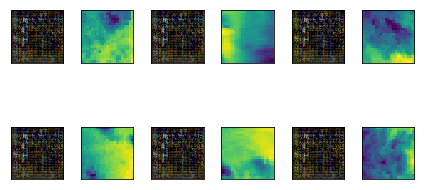

epoch = 222/1000, d_loss=0.163, g_loss=0.067                                                                                                                      
epoch = 223/1000, d_loss=0.163, g_loss=0.068                                                                                                                      
epoch = 224/1000, d_loss=0.163, g_loss=0.067                                                                                                                      
epoch = 225/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 226/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 227/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 228/1000, d

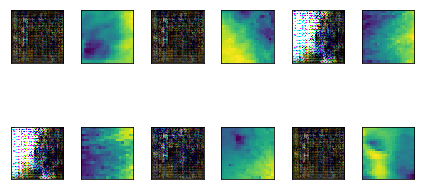

epoch = 232/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 233/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 234/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 235/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 236/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 237/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 238/1000

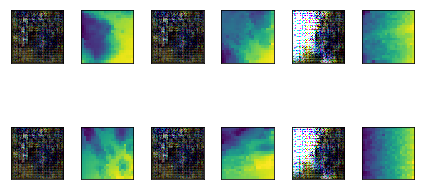

epoch = 242/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 243/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 244/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 245/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 246/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 247/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 248/1000

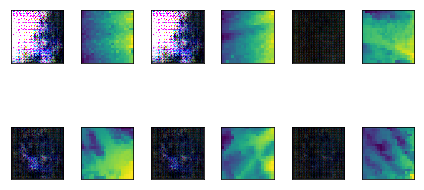

epoch = 252/1000, d_loss=0.163, g_loss=0.092                                                                                                                      
epoch = 253/1000, d_loss=0.163, g_loss=0.090                                                                                                                      
epoch = 254/1000, d_loss=0.163, g_loss=0.086                                                                                                                      
epoch = 255/1000, d_loss=0.163, g_loss=0.083                                                                                                                      
epoch = 256/1000, d_loss=0.168, g_loss=0.086                                                                                                                      
epoch = 257/1000, d_loss=0.163, g_loss=0.082                                                                                                                      
epoch = 258/1000, d_lo

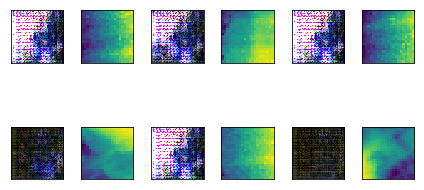

epoch = 262/1000, d_loss=0.163, g_loss=0.076                                                                                                                      
epoch = 263/1000, d_loss=0.163, g_loss=0.075                                                                                                                      
epoch = 264/1000, d_loss=0.163, g_loss=0.075                                                                                                                      
epoch = 265/1000, d_loss=0.163, g_loss=0.081                                                                                                                      
epoch = 266/1000, d_loss=0.163, g_loss=0.080                                                                                                                      
epoch = 267/1000, d_loss=0.163, g_loss=0.076                                                                                                                      
epoch = 268/1000, d_lo

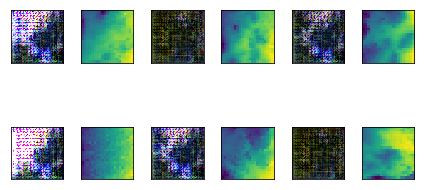

epoch = 272/1000, d_loss=0.163, g_loss=0.073                                                                                                                      
epoch = 273/1000, d_loss=0.163, g_loss=0.072                                                                                                                      
epoch = 274/1000, d_loss=0.163, g_loss=0.071                                                                                                                      
epoch = 275/1000, d_loss=0.163, g_loss=0.082                                                                                                                      
epoch = 276/1000, d_loss=0.163, g_loss=0.074                                                                                                                      
epoch = 277/1000, d_loss=0.163, g_loss=0.072                                                                                                                      
epoch = 278/1000, d_lo

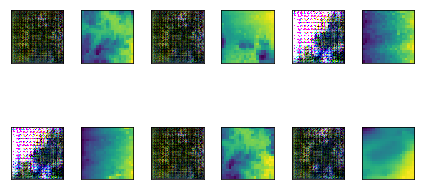

epoch = 282/1000, d_loss=0.163, g_loss=0.069                                                                                                                      
epoch = 283/1000, d_loss=0.163, g_loss=0.068                                                                                                                      
epoch = 284/1000, d_loss=0.163, g_loss=0.069                                                                                                                      
epoch = 285/1000, d_loss=0.163, g_loss=0.070                                                                                                                      
epoch = 286/1000, d_loss=0.163, g_loss=0.070                                                                                                                      
epoch = 287/1000, d_loss=0.163, g_loss=0.071                                                                                                                      
epoch = 288/1000, d_lo

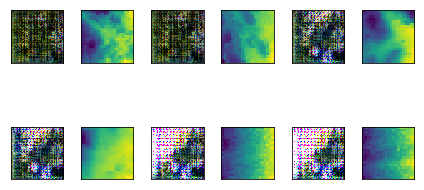

epoch = 292/1000, d_loss=0.163, g_loss=0.072                                                                                                                      
epoch = 293/1000, d_loss=0.163, g_loss=0.072                                                                                                                      
epoch = 294/1000, d_loss=0.163, g_loss=0.069                                                                                                                      
epoch = 295/1000, d_loss=0.163, g_loss=0.067                                                                                                                      
epoch = 296/1000, d_loss=0.163, g_loss=0.067                                                                                                                      
epoch = 297/1000, d_loss=0.163, g_loss=0.059                                                                                                                      
epoch = 298/1000, d_lo

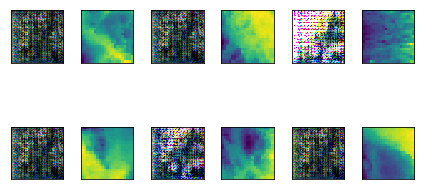

epoch = 302/1000, d_loss=0.163, g_loss=0.065                                                                                                                      
epoch = 303/1000, d_loss=0.163, g_loss=0.061                                                                                                                      
epoch = 304/1000, d_loss=0.163, g_loss=0.062                                                                                                                      
epoch = 305/1000, d_loss=0.163, g_loss=15.981                                                                                                                      
epoch = 306/1000, d_loss=0.163, g_loss=0.099                                                                                                                      
epoch = 307/1000, d_loss=0.163, g_loss=0.095                                                                                                                      
epoch = 308/1000, d_l

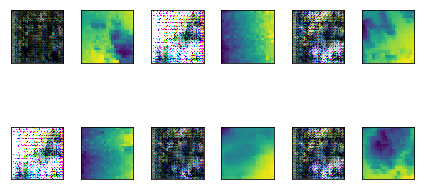

epoch = 312/1000, d_loss=0.163, g_loss=0.082                                                                                                                      
epoch = 313/1000, d_loss=0.163, g_loss=0.080                                                                                                                      
epoch = 314/1000, d_loss=0.163, g_loss=0.079                                                                                                                      
epoch = 315/1000, d_loss=0.163, g_loss=0.078                                                                                                                      
epoch = 316/1000, d_loss=0.163, g_loss=0.209                                                                                                                       
epoch = 317/1000, d_loss=0.163, g_loss=0.103                                                                                                                      
epoch = 318/1000, d_l

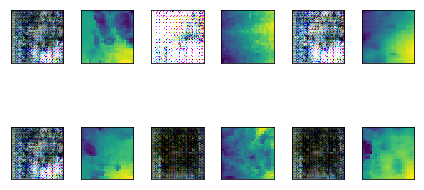

epoch = 322/1000, d_loss=0.163, g_loss=0.073                                                                                                                      
epoch = 323/1000, d_loss=0.163, g_loss=0.072                                                                                                                      
epoch = 324/1000, d_loss=0.163, g_loss=0.072                                                                                                                      
epoch = 325/1000, d_loss=0.163, g_loss=0.070                                                                                                                      
epoch = 326/1000, d_loss=0.164, g_loss=0.123                                                                                                                       
epoch = 327/1000, d_loss=0.163, g_loss=0.199                                                                                                                       
epoch = 328/1000, d_

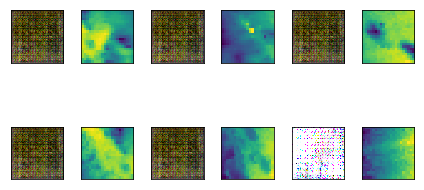

epoch = 332/1000, d_loss=0.163, g_loss=0.093                                                                                                                      
epoch = 333/1000, d_loss=0.163, g_loss=0.090                                                                                                                      
epoch = 334/1000, d_loss=0.163, g_loss=0.087                                                                                                                      
epoch = 335/1000, d_loss=0.163, g_loss=0.084                                                                                                                      
epoch = 336/1000, d_loss=0.163, g_loss=0.084                                                                                                                      
epoch = 337/1000, d_loss=0.163, g_loss=0.081                                                                                                                      
epoch = 338/1000, d_lo

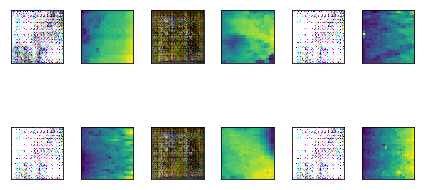

epoch = 342/1000, d_loss=0.163, g_loss=0.074                                                                                                                      
epoch = 343/1000, d_loss=0.163, g_loss=0.083                                                                                                                      
epoch = 344/1000, d_loss=0.163, g_loss=0.072                                                                                                                      
epoch = 345/1000, d_loss=0.163, g_loss=0.072                                                                                                                      
epoch = 346/1000, d_loss=0.163, g_loss=0.074                                                                                                                      
epoch = 347/1000, d_loss=0.163, g_loss=0.076                                                                                                                      
epoch = 348/1000, d_lo

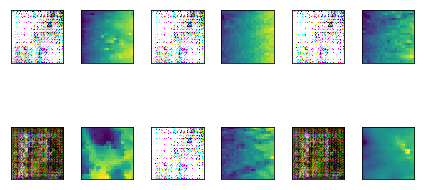

epoch = 352/1000, d_loss=0.163, g_loss=0.073                                                                                                                      
epoch = 353/1000, d_loss=0.163, g_loss=0.070                                                                                                                      
epoch = 354/1000, d_loss=0.163, g_loss=0.069                                                                                                                      
epoch = 355/1000, d_loss=0.163, g_loss=0.069                                                                                                                      
epoch = 356/1000, d_loss=0.163, g_loss=0.068                                                                                                                      
epoch = 357/1000, d_loss=0.163, g_loss=0.070                                                                                                                      
epoch = 358/1000, d_lo

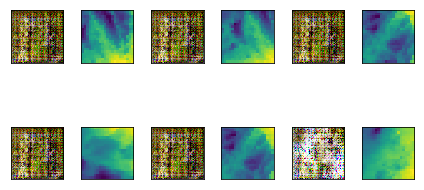

epoch = 362/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 363/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 364/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 365/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 366/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 367/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 368/1000

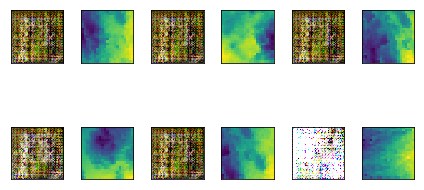

epoch = 372/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 373/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 374/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 375/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 376/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 377/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 378/1000

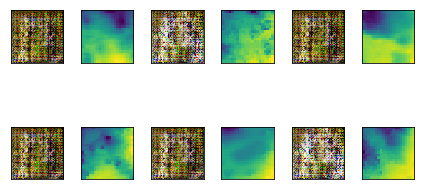

epoch = 382/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 383/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 384/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 385/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 386/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 387/1000, d_loss=0.163, g_loss=0.184                                                                                                                       
epoch = 388/1000

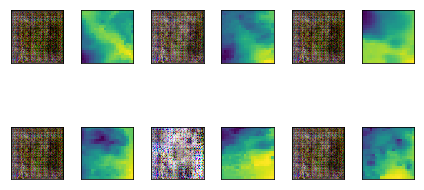

epoch = 392/1000, d_loss=0.163, g_loss=0.090                                                                                                                      
epoch = 393/1000, d_loss=0.163, g_loss=0.089                                                                                                                      
epoch = 394/1000, d_loss=0.163, g_loss=0.085                                                                                                                      
epoch = 395/1000, d_loss=0.163, g_loss=0.064                                                                                                                      
epoch = 396/1000, d_loss=0.163, g_loss=0.054                                                                                                                      
epoch = 397/1000, d_loss=0.163, g_loss=0.056                                                                                                                      
epoch = 398/1000, d_lo

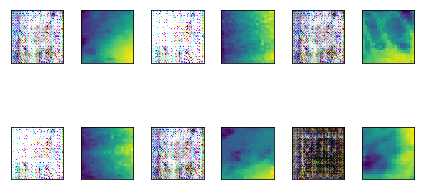

epoch = 402/1000, d_loss=0.163, g_loss=0.093                                                                                                                      
epoch = 403/1000, d_loss=0.163, g_loss=0.089                                                                                                                      
epoch = 404/1000, d_loss=0.163, g_loss=3.402                                                                                                                      
epoch = 405/1000, d_loss=0.163, g_loss=0.089                                                                                                                      
epoch = 406/1000, d_loss=0.163, g_loss=0.082                                                                                                                      
epoch = 407/1000, d_loss=0.163, g_loss=0.080                                                                                                                      
epoch = 408/1000, d_lo

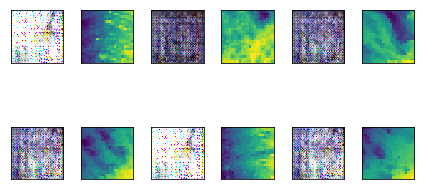

epoch = 412/1000, d_loss=0.163, g_loss=0.069                                                                                                                      
epoch = 413/1000, d_loss=0.163, g_loss=0.066                                                                                                                      
epoch = 414/1000, d_loss=0.163, g_loss=0.065                                                                                                                      
epoch = 415/1000, d_loss=0.163, g_loss=0.065                                                                                                                      
epoch = 416/1000, d_loss=0.163, g_loss=0.067                                                                                                                      
epoch = 417/1000, d_loss=0.163, g_loss=0.059                                                                                                                      
epoch = 418/1000, d_lo

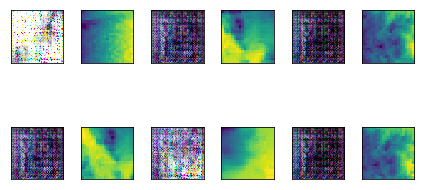

epoch = 422/1000, d_loss=0.163, g_loss=0.065                                                                                                                      
epoch = 423/1000, d_loss=0.163, g_loss=0.060                                                                                                                      
epoch = 424/1000, d_loss=0.163, g_loss=0.061                                                                                                                      
epoch = 425/1000, d_loss=0.163, g_loss=0.061                                                                                                                      
epoch = 426/1000, d_loss=0.163, g_loss=0.058                                                                                                                      
epoch = 427/1000, d_loss=0.163, g_loss=0.057                                                                                                                      
epoch = 428/1000, d_lo

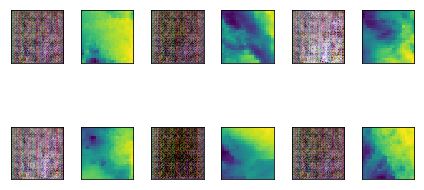

epoch = 432/1000, d_loss=0.163, g_loss=0.096                                                                                                                      
epoch = 433/1000, d_loss=0.163, g_loss=0.094                                                                                                                      
epoch = 434/1000, d_loss=0.163, g_loss=0.092                                                                                                                      
epoch = 435/1000, d_loss=0.163, g_loss=0.090                                                                                                                      
epoch = 436/1000, d_loss=0.163, g_loss=0.088                                                                                                                      
epoch = 437/1000, d_loss=0.163, g_loss=0.087                                                                                                                      
epoch = 438/1000, d_lo

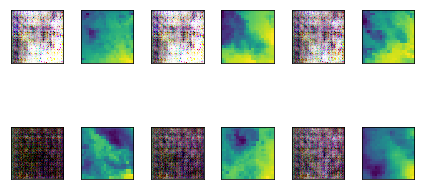

epoch = 442/1000, d_loss=0.163, g_loss=0.084                                                                                                                      
epoch = 443/1000, d_loss=0.163, g_loss=0.083                                                                                                                      
epoch = 444/1000, d_loss=0.163, g_loss=0.081                                                                                                                      
epoch = 445/1000, d_loss=0.163, g_loss=0.084                                                                                                                      
epoch = 446/1000, d_loss=0.163, g_loss=0.080                                                                                                                      
epoch = 447/1000, d_loss=0.163, g_loss=0.079                                                                                                                      
epoch = 448/1000, d_lo

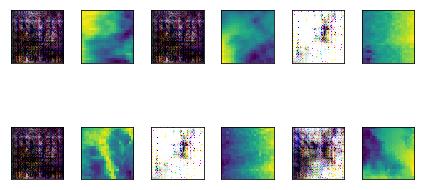

epoch = 452/1000, d_loss=0.163, g_loss=0.078                                                                                                                      
epoch = 453/1000, d_loss=0.163, g_loss=0.100                                                                                                                      
epoch = 454/1000, d_loss=0.163, g_loss=0.098                                                                                                                      
epoch = 455/1000, d_loss=0.163, g_loss=0.093                                                                                                                      
epoch = 456/1000, d_loss=0.163, g_loss=0.089                                                                                                                      
epoch = 457/1000, d_loss=0.163, g_loss=0.087                                                                                                                      
epoch = 458/1000, d_lo

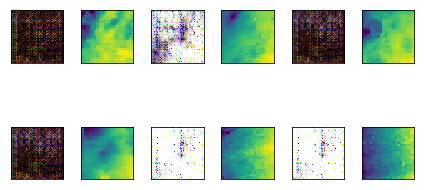

epoch = 462/1000, d_loss=0.163, g_loss=0.079                                                                                                                      
epoch = 463/1000, d_loss=0.163, g_loss=0.077                                                                                                                      
epoch = 464/1000, d_loss=0.163, g_loss=0.077                                                                                                                      
epoch = 465/1000, d_loss=0.163, g_loss=0.076                                                                                                                      
epoch = 466/1000, d_loss=0.163, g_loss=0.077                                                                                                                      
epoch = 467/1000, d_loss=0.163, g_loss=0.074                                                                                                                      
epoch = 468/1000, d_lo

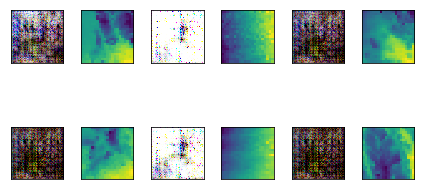

epoch = 472/1000, d_loss=0.163, g_loss=0.078                                                                                                                      
epoch = 473/1000, d_loss=0.163, g_loss=0.074                                                                                                                      
epoch = 474/1000, d_loss=0.163, g_loss=0.077                                                                                                                      
epoch = 475/1000, d_loss=0.163, g_loss=0.072                                                                                                                      
epoch = 476/1000, d_loss=0.163, g_loss=0.071                                                                                                                      
epoch = 477/1000, d_loss=0.163, g_loss=0.073                                                                                                                      
epoch = 478/1000, d_lo

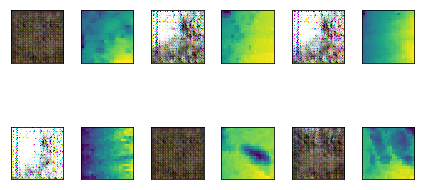

epoch = 482/1000, d_loss=0.166, g_loss=0.100                                                                                                                      
epoch = 483/1000, d_loss=0.163, g_loss=0.098                                                                                                                      
epoch = 484/1000, d_loss=0.163, g_loss=0.094                                                                                                                      
epoch = 485/1000, d_loss=0.163, g_loss=0.093                                                                                                                      
epoch = 486/1000, d_loss=0.163, g_loss=0.090                                                                                                                      
epoch = 487/1000, d_loss=0.163, g_loss=0.085                                                                                                                      
epoch = 488/1000, d_lo

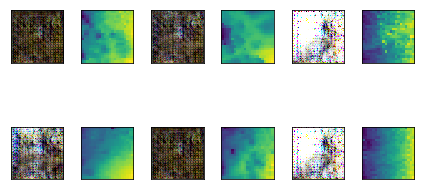

epoch = 492/1000, d_loss=0.163, g_loss=0.077                                                                                                                      
epoch = 493/1000, d_loss=0.163, g_loss=0.088                                                                                                                      
epoch = 494/1000, d_loss=0.163, g_loss=0.081                                                                                                                      
epoch = 495/1000, d_loss=0.163, g_loss=0.076                                                                                                                      
epoch = 496/1000, d_loss=0.163, g_loss=0.079                                                                                                                      
epoch = 497/1000, d_loss=0.163, g_loss=0.078                                                                                                                      
epoch = 498/1000, d_lo

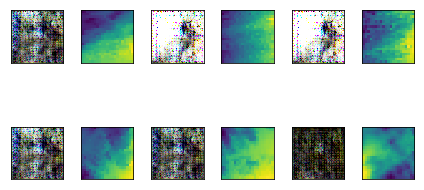

epoch = 502/1000, d_loss=0.163, g_loss=0.074                                                                                                                      
epoch = 503/1000, d_loss=0.163, g_loss=0.075                                                                                                                      
epoch = 504/1000, d_loss=0.163, g_loss=0.078                                                                                                                      
epoch = 505/1000, d_loss=0.163, g_loss=0.074                                                                                                                      
epoch = 506/1000, d_loss=0.163, g_loss=0.074                                                                                                                      
epoch = 507/1000, d_loss=0.163, g_loss=0.072                                                                                                                      
epoch = 508/1000, d_lo

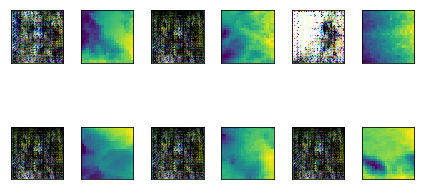

epoch = 512/1000, d_loss=0.163, g_loss=0.072                                                                                                                      
epoch = 513/1000, d_loss=0.163, g_loss=0.071                                                                                                                      
epoch = 514/1000, d_loss=0.163, g_loss=0.069                                                                                                                      
epoch = 515/1000, d_loss=0.163, g_loss=0.070                                                                                                                      
epoch = 516/1000, d_loss=0.163, g_loss=0.075                                                                                                                      
epoch = 517/1000, d_loss=0.163, g_loss=0.068                                                                                                                      
epoch = 518/1000, d_lo

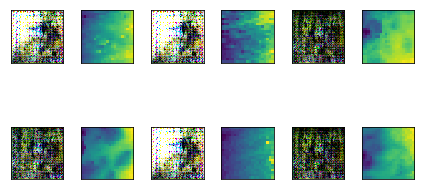

epoch = 522/1000, d_loss=0.163, g_loss=0.073                                                                                                                      
epoch = 523/1000, d_loss=0.163, g_loss=0.069                                                                                                                      
epoch = 524/1000, d_loss=0.163, g_loss=0.070                                                                                                                      
epoch = 525/1000, d_loss=0.163, g_loss=0.068                                                                                                                      
epoch = 526/1000, d_loss=0.163, g_loss=0.076                                                                                                                      
epoch = 527/1000, d_loss=0.163, g_loss=0.075                                                                                                                      
epoch = 528/1000, d_lo

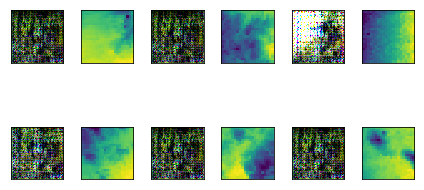

epoch = 532/1000, d_loss=0.163, g_loss=0.075                                                                                                                      
epoch = 533/1000, d_loss=0.163, g_loss=0.072                                                                                                                      
epoch = 534/1000, d_loss=0.163, g_loss=0.071                                                                                                                      
epoch = 535/1000, d_loss=0.163, g_loss=0.074                                                                                                                      
epoch = 536/1000, d_loss=0.163, g_loss=0.074                                                                                                                      
epoch = 537/1000, d_loss=0.163, g_loss=0.069                                                                                                                      
epoch = 538/1000, d_lo

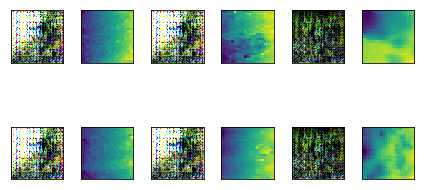

epoch = 542/1000, d_loss=0.163, g_loss=0.072                                                                                                                      
epoch = 543/1000, d_loss=0.163, g_loss=0.074                                                                                                                      
epoch = 544/1000, d_loss=0.163, g_loss=0.069                                                                                                                      
epoch = 545/1000, d_loss=0.163, g_loss=0.084                                                                                                                      
epoch = 546/1000, d_loss=0.163, g_loss=0.070                                                                                                                      
epoch = 547/1000, d_loss=0.163, g_loss=0.068                                                                                                                      
epoch = 548/1000, d_lo

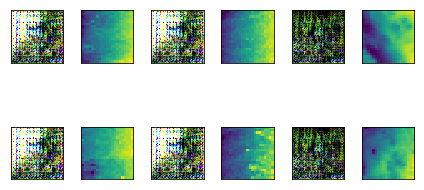

epoch = 552/1000, d_loss=0.163, g_loss=0.072                                                                                                                      
epoch = 553/1000, d_loss=0.163, g_loss=0.073                                                                                                                      
epoch = 554/1000, d_loss=0.163, g_loss=0.073                                                                                                                      
epoch = 555/1000, d_loss=0.163, g_loss=0.071                                                                                                                      
epoch = 556/1000, d_loss=0.163, g_loss=0.071                                                                                                                      
epoch = 557/1000, d_loss=0.163, g_loss=0.074                                                                                                                      
epoch = 558/1000, d_lo

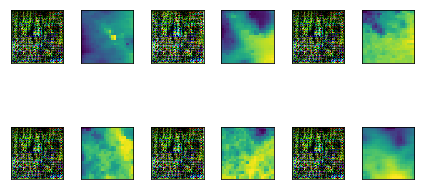

epoch = 562/1000, d_loss=0.163, g_loss=0.069                                                                                                                      
epoch = 563/1000, d_loss=0.163, g_loss=0.067                                                                                                                      
epoch = 564/1000, d_loss=0.163, g_loss=0.068                                                                                                                      
epoch = 565/1000, d_loss=0.163, g_loss=0.072                                                                                                                      
epoch = 566/1000, d_loss=0.163, g_loss=0.067                                                                                                                      
epoch = 567/1000, d_loss=0.163, g_loss=0.067                                                                                                                      
epoch = 568/1000, d_lo

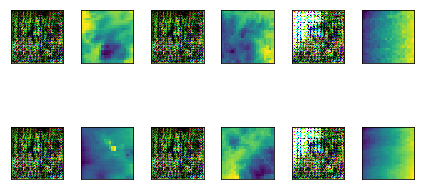

epoch = 572/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 573/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 574/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 575/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 576/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 577/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 578/1000

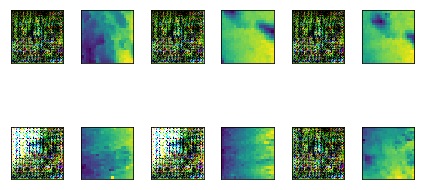

epoch = 582/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 583/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 584/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 585/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 586/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 587/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 588/1000

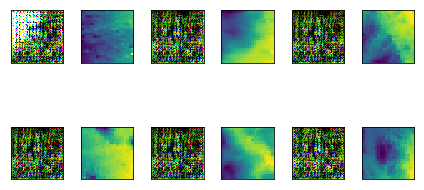

epoch = 592/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 593/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 594/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 595/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 596/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 597/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 598/1000

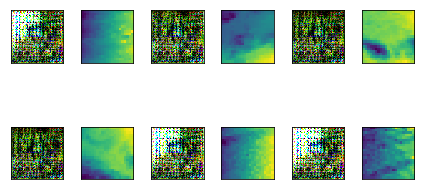

epoch = 602/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 603/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 604/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 605/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 606/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 607/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 608/1000

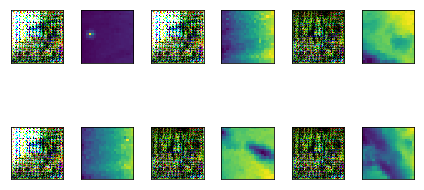

epoch = 612/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 613/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 614/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 615/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 616/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 617/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 618/1000

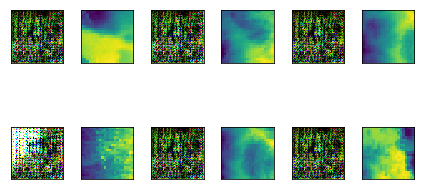

epoch = 622/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 623/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 624/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 625/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 626/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 627/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 628/1000

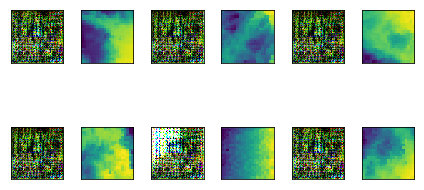

epoch = 632/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 633/1000, d_loss=0.163, g_loss=0.105                                                                                                                       
epoch = 634/1000, d_loss=0.163, g_loss=0.102                                                                                                                      
epoch = 635/1000, d_loss=0.163, g_loss=0.101                                                                                                                      
epoch = 636/1000, d_loss=0.163, g_loss=0.095                                                                                                                      
epoch = 637/1000, d_loss=0.163, g_loss=0.092                                                                                                                      
epoch = 638/1000, d_

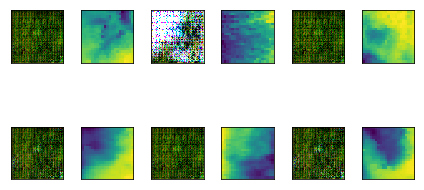

epoch = 642/1000, d_loss=0.163, g_loss=0.085                                                                                                                      
epoch = 643/1000, d_loss=0.163, g_loss=0.087                                                                                                                      
epoch = 644/1000, d_loss=0.163, g_loss=0.084                                                                                                                      
epoch = 645/1000, d_loss=0.163, g_loss=0.087                                                                                                                      
epoch = 646/1000, d_loss=0.163, g_loss=0.082                                                                                                                      
epoch = 647/1000, d_loss=0.163, g_loss=0.081                                                                                                                      
epoch = 648/1000, d_lo

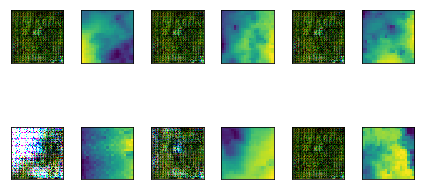

epoch = 652/1000, d_loss=0.163, g_loss=0.078                                                                                                                      
epoch = 653/1000, d_loss=0.163, g_loss=0.085                                                                                                                      
epoch = 654/1000, d_loss=0.163, g_loss=0.080                                                                                                                      
epoch = 655/1000, d_loss=0.163, g_loss=0.079                                                                                                                      
epoch = 656/1000, d_loss=0.163, g_loss=0.079                                                                                                                      
epoch = 657/1000, d_loss=0.163, g_loss=0.078                                                                                                                      
epoch = 658/1000, d_lo

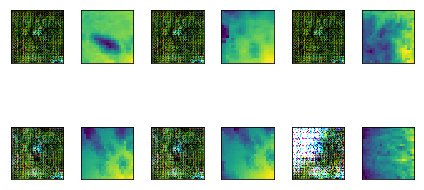

epoch = 662/1000, d_loss=0.163, g_loss=0.079                                                                                                                      
epoch = 663/1000, d_loss=0.163, g_loss=0.079                                                                                                                      
epoch = 664/1000, d_loss=0.163, g_loss=0.081                                                                                                                      
epoch = 665/1000, d_loss=0.163, g_loss=0.087                                                                                                                      
epoch = 666/1000, d_loss=0.163, g_loss=0.082                                                                                                                      
epoch = 667/1000, d_loss=0.163, g_loss=0.085                                                                                                                      
epoch = 668/1000, d_lo

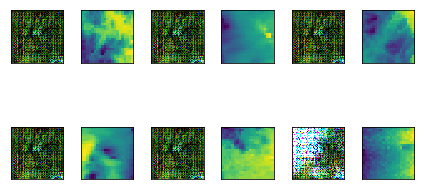

epoch = 672/1000, d_loss=0.163, g_loss=0.078                                                                                                                      
epoch = 673/1000, d_loss=0.163, g_loss=0.081                                                                                                                      
epoch = 674/1000, d_loss=0.163, g_loss=0.089                                                                                                                      
epoch = 675/1000, d_loss=0.163, g_loss=0.082                                                                                                                      
epoch = 676/1000, d_loss=0.163, g_loss=0.080                                                                                                                      
epoch = 677/1000, d_loss=0.163, g_loss=0.082                                                                                                                      
epoch = 678/1000, d_lo

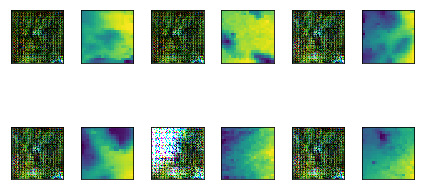

epoch = 682/1000, d_loss=0.163, g_loss=0.076                                                                                                                      
epoch = 683/1000, d_loss=0.163, g_loss=0.076                                                                                                                      
epoch = 684/1000, d_loss=0.163, g_loss=0.079                                                                                                                      
epoch = 685/1000, d_loss=0.163, g_loss=0.080                                                                                                                      
epoch = 686/1000, d_loss=0.163, g_loss=0.074                                                                                                                      
epoch = 687/1000, d_loss=0.163, g_loss=6.678                                                                                                                       
epoch = 688/1000, d_l

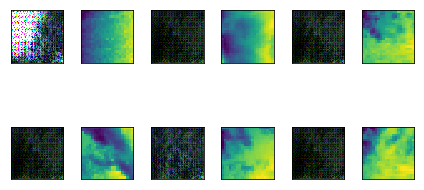

epoch = 692/1000, d_loss=0.163, g_loss=0.095                                                                                                                      
epoch = 693/1000, d_loss=0.163, g_loss=0.093                                                                                                                      
epoch = 694/1000, d_loss=0.163, g_loss=0.092                                                                                                                      
epoch = 695/1000, d_loss=0.163, g_loss=0.091                                                                                                                      
epoch = 696/1000, d_loss=0.163, g_loss=0.090                                                                                                                      
epoch = 697/1000, d_loss=0.163, g_loss=0.087                                                                                                                      
epoch = 698/1000, d_lo

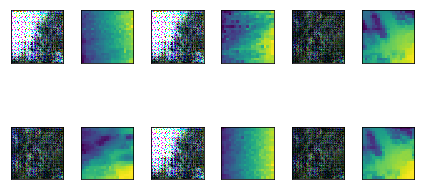

epoch = 702/1000, d_loss=0.163, g_loss=0.084                                                                                                                      
epoch = 703/1000, d_loss=0.163, g_loss=0.084                                                                                                                      
epoch = 704/1000, d_loss=0.163, g_loss=0.085                                                                                                                      
epoch = 705/1000, d_loss=0.163, g_loss=0.083                                                                                                                      
epoch = 706/1000, d_loss=0.163, g_loss=0.085                                                                                                                      
epoch = 707/1000, d_loss=0.163, g_loss=0.084                                                                                                                      
epoch = 708/1000, d_lo

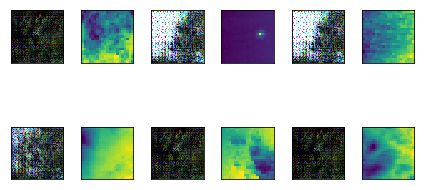

epoch = 712/1000, d_loss=0.163, g_loss=0.083                                                                                                                      
epoch = 713/1000, d_loss=0.163, g_loss=0.083                                                                                                                      
epoch = 714/1000, d_loss=0.163, g_loss=0.083                                                                                                                      
epoch = 715/1000, d_loss=0.163, g_loss=0.082                                                                                                                      
epoch = 716/1000, d_loss=0.163, g_loss=0.084                                                                                                                      
epoch = 717/1000, d_loss=0.163, g_loss=0.084                                                                                                                      
epoch = 718/1000, d_lo

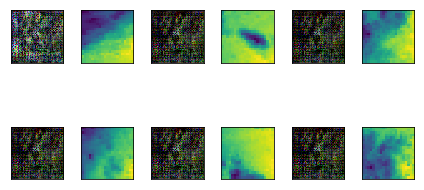

epoch = 722/1000, d_loss=0.163, g_loss=0.083                                                                                                                      
epoch = 723/1000, d_loss=0.163, g_loss=0.086                                                                                                                      
epoch = 724/1000, d_loss=0.163, g_loss=0.083                                                                                                                      
epoch = 725/1000, d_loss=0.163, g_loss=0.084                                                                                                                      
epoch = 726/1000, d_loss=0.163, g_loss=0.081                                                                                                                      
epoch = 727/1000, d_loss=0.163, g_loss=0.082                                                                                                                      
epoch = 728/1000, d_lo

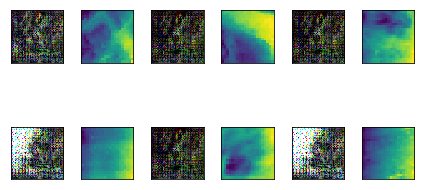

epoch = 732/1000, d_loss=0.163, g_loss=0.081                                                                                                                      
epoch = 733/1000, d_loss=0.163, g_loss=0.081                                                                                                                      
epoch = 734/1000, d_loss=0.163, g_loss=0.085                                                                                                                      
epoch = 735/1000, d_loss=0.163, g_loss=0.082                                                                                                                      
epoch = 736/1000, d_loss=0.163, g_loss=0.079                                                                                                                      
epoch = 737/1000, d_loss=0.163, g_loss=0.081                                                                                                                      
epoch = 738/1000, d_lo

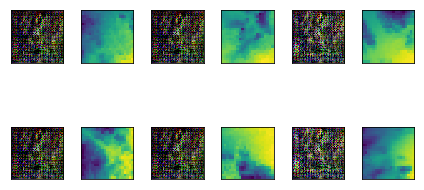

epoch = 742/1000, d_loss=0.163, g_loss=0.079                                                                                                                      
epoch = 743/1000, d_loss=0.163, g_loss=0.083                                                                                                                      
epoch = 744/1000, d_loss=0.163, g_loss=0.084                                                                                                                      
epoch = 745/1000, d_loss=0.163, g_loss=0.081                                                                                                                      
epoch = 746/1000, d_loss=0.163, g_loss=0.080                                                                                                                      
epoch = 747/1000, d_loss=0.163, g_loss=0.084                                                                                                                      
epoch = 748/1000, d_lo

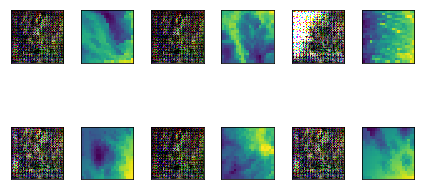

epoch = 752/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 753/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 754/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 755/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 756/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 757/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 758/1000

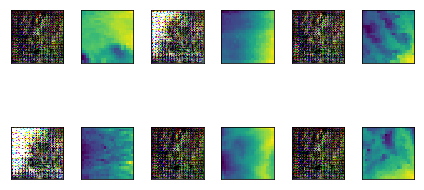

epoch = 762/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 763/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 764/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 765/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 766/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 767/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 768/1000

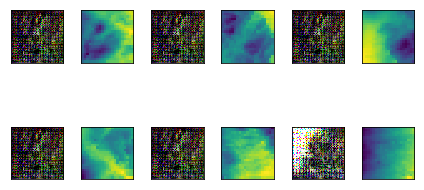

epoch = 772/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 773/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 774/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 775/1000, d_loss=0.163, g_loss=0.090                                                                                                                      
epoch = 776/1000, d_loss=0.163, g_loss=0.086                                                                                                                      
epoch = 777/1000, d_loss=0.163, g_loss=0.084                                                                                                                      
epoch = 778/1000, d

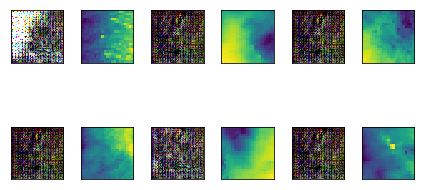

epoch = 782/1000, d_loss=0.163, g_loss=0.083                                                                                                                      
epoch = 783/1000, d_loss=0.163, g_loss=0.085                                                                                                                      
epoch = 784/1000, d_loss=0.163, g_loss=0.085                                                                                                                      
epoch = 785/1000, d_loss=0.163, g_loss=0.082                                                                                                                      
epoch = 786/1000, d_loss=0.163, g_loss=0.081                                                                                                                      
epoch = 787/1000, d_loss=0.163, g_loss=0.080                                                                                                                      
epoch = 788/1000, d_lo

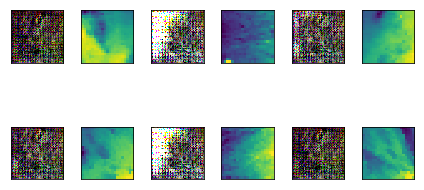

epoch = 792/1000, d_loss=0.163, g_loss=0.084                                                                                                                      
epoch = 793/1000, d_loss=0.163, g_loss=0.081                                                                                                                      
epoch = 794/1000, d_loss=0.163, g_loss=0.082                                                                                                                      
epoch = 795/1000, d_loss=0.163, g_loss=0.081                                                                                                                      
epoch = 796/1000, d_loss=0.163, g_loss=0.084                                                                                                                      
epoch = 797/1000, d_loss=0.163, g_loss=0.082                                                                                                                      
epoch = 798/1000, d_lo

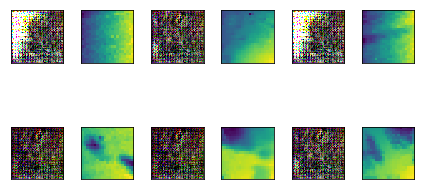

epoch = 802/1000, d_loss=0.163, g_loss=0.085                                                                                                                      
epoch = 803/1000, d_loss=0.163, g_loss=0.082                                                                                                                      
epoch = 804/1000, d_loss=0.163, g_loss=0.081                                                                                                                      
epoch = 805/1000, d_loss=0.163, g_loss=0.080                                                                                                                      
epoch = 806/1000, d_loss=0.163, g_loss=0.082                                                                                                                      
epoch = 807/1000, d_loss=0.163, g_loss=0.081                                                                                                                      
epoch = 808/1000, d_lo

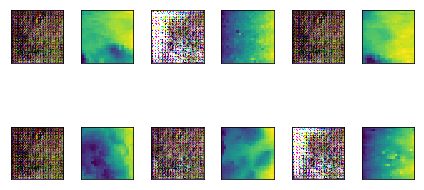

epoch = 812/1000, d_loss=0.163, g_loss=0.087                                                                                                                      
epoch = 813/1000, d_loss=0.163, g_loss=0.082                                                                                                                      
epoch = 814/1000, d_loss=0.163, g_loss=0.068                                                                                                                      
epoch = 815/1000, d_loss=0.163, g_loss=0.065                                                                                                                      
epoch = 816/1000, d_loss=0.163, g_loss=0.056                                                                                                                      
epoch = 817/1000, d_loss=0.163, g_loss=0.053                                                                                                                      
epoch = 818/1000, d_lo

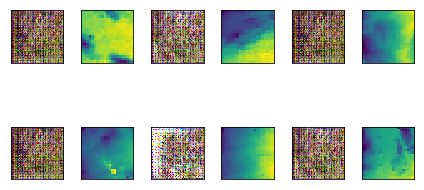

epoch = 822/1000, d_loss=0.163, g_loss=0.113                                                                                                                       
epoch = 823/1000, d_loss=0.163, g_loss=0.088                                                                                                                      
epoch = 824/1000, d_loss=0.163, g_loss=0.085                                                                                                                      
epoch = 825/1000, d_loss=0.163, g_loss=0.073                                                                                                                      
epoch = 826/1000, d_loss=0.163, g_loss=0.073                                                                                                                      
epoch = 827/1000, d_loss=0.163, g_loss=0.069                                                                                                                      
epoch = 828/1000, d_l

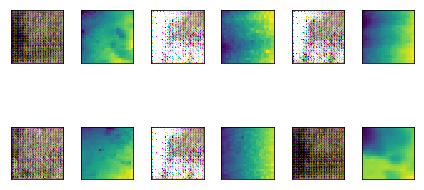

epoch = 832/1000, d_loss=0.163, g_loss=0.099                                                                                                                      
epoch = 833/1000, d_loss=0.163, g_loss=0.095                                                                                                                      
epoch = 834/1000, d_loss=0.163, g_loss=0.095                                                                                                                      
epoch = 835/1000, d_loss=0.163, g_loss=0.095                                                                                                                      
epoch = 836/1000, d_loss=0.163, g_loss=0.094                                                                                                                      
epoch = 837/1000, d_loss=0.163, g_loss=0.093                                                                                                                      
epoch = 838/1000, d_lo

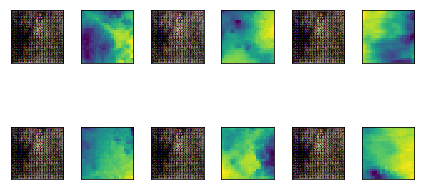

epoch = 842/1000, d_loss=0.163, g_loss=0.094                                                                                                                      
epoch = 843/1000, d_loss=0.163, g_loss=0.090                                                                                                                      
epoch = 844/1000, d_loss=0.163, g_loss=0.091                                                                                                                      
epoch = 845/1000, d_loss=0.163, g_loss=0.091                                                                                                                      
epoch = 846/1000, d_loss=0.163, g_loss=0.091                                                                                                                      
epoch = 847/1000, d_loss=0.163, g_loss=0.088                                                                                                                      
epoch = 848/1000, d_lo

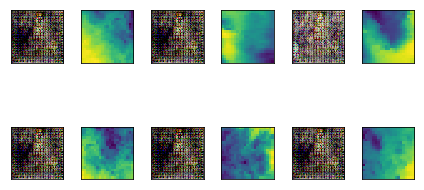

epoch = 852/1000, d_loss=0.163, g_loss=0.088                                                                                                                      
epoch = 853/1000, d_loss=0.163, g_loss=0.085                                                                                                                      
epoch = 854/1000, d_loss=0.163, g_loss=0.086                                                                                                                      
epoch = 855/1000, d_loss=0.163, g_loss=0.085                                                                                                                      
epoch = 856/1000, d_loss=0.163, g_loss=0.085                                                                                                                      
epoch = 857/1000, d_loss=0.163, g_loss=0.085                                                                                                                      
epoch = 858/1000, d_lo

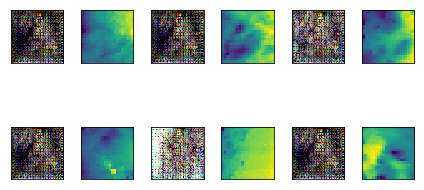

epoch = 862/1000, d_loss=0.163, g_loss=0.085                                                                                                                      
epoch = 863/1000, d_loss=0.163, g_loss=0.085                                                                                                                      
epoch = 864/1000, d_loss=0.163, g_loss=0.082                                                                                                                      
epoch = 865/1000, d_loss=0.163, g_loss=0.085                                                                                                                      
epoch = 866/1000, d_loss=0.163, g_loss=0.085                                                                                                                      
epoch = 867/1000, d_loss=0.163, g_loss=0.083                                                                                                                      
epoch = 868/1000, d_lo

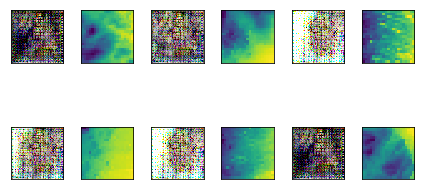

epoch = 872/1000, d_loss=0.163, g_loss=0.083                                                                                                                      
epoch = 873/1000, d_loss=0.163, g_loss=0.083                                                                                                                      
epoch = 874/1000, d_loss=0.163, g_loss=0.083                                                                                                                      
epoch = 875/1000, d_loss=0.163, g_loss=0.082                                                                                                                      
epoch = 876/1000, d_loss=0.163, g_loss=0.084                                                                                                                      
epoch = 877/1000, d_loss=0.163, g_loss=0.080                                                                                                                      
epoch = 878/1000, d_lo

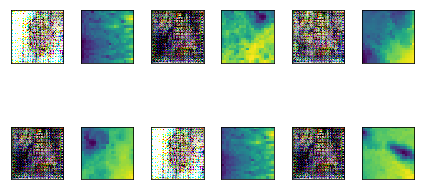

epoch = 882/1000, d_loss=0.163, g_loss=0.080                                                                                                                      
epoch = 883/1000, d_loss=0.163, g_loss=0.077                                                                                                                      
epoch = 884/1000, d_loss=0.163, g_loss=0.078                                                                                                                      
epoch = 885/1000, d_loss=0.163, g_loss=0.084                                                                                                                      
epoch = 886/1000, d_loss=0.163, g_loss=0.079                                                                                                                      
epoch = 887/1000, d_loss=0.163, g_loss=0.082                                                                                                                      
epoch = 888/1000, d_lo

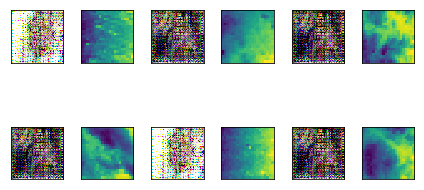

epoch = 892/1000, d_loss=0.163, g_loss=0.873                                                                                                                       
epoch = 893/1000, d_loss=0.163, g_loss=0.108                                                                                                                      
epoch = 894/1000, d_loss=0.163, g_loss=0.106                                                                                                                      
epoch = 895/1000, d_loss=0.163, g_loss=0.105                                                                                                                      
epoch = 896/1000, d_loss=0.163, g_loss=0.104                                                                                                                      
epoch = 897/1000, d_loss=0.163, g_loss=0.102                                                                                                                      
epoch = 898/1000, d_l

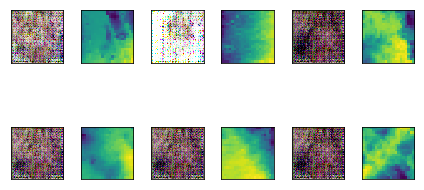

epoch = 902/1000, d_loss=0.163, g_loss=0.095                                                                                                                      
epoch = 903/1000, d_loss=0.163, g_loss=0.093                                                                                                                      
epoch = 904/1000, d_loss=0.163, g_loss=0.092                                                                                                                      
epoch = 905/1000, d_loss=0.163, g_loss=0.092                                                                                                                      
epoch = 906/1000, d_loss=0.163, g_loss=0.091                                                                                                                      
epoch = 907/1000, d_loss=0.163, g_loss=0.089                                                                                                                      
epoch = 908/1000, d_lo

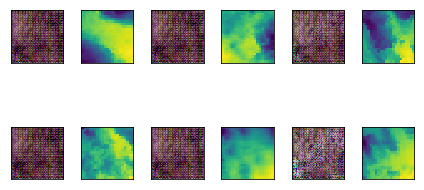

epoch = 912/1000, d_loss=0.163, g_loss=0.103                                                                                                                      
epoch = 913/1000, d_loss=0.163, g_loss=0.101                                                                                                                      
epoch = 914/1000, d_loss=0.163, g_loss=0.100                                                                                                                      
epoch = 915/1000, d_loss=0.163, g_loss=0.098                                                                                                                      
epoch = 916/1000, d_loss=0.163, g_loss=0.095                                                                                                                      
epoch = 917/1000, d_loss=0.163, g_loss=0.094                                                                                                                      
epoch = 918/1000, d_lo

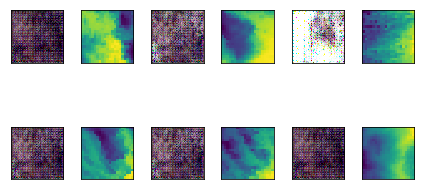

epoch = 922/1000, d_loss=0.163, g_loss=0.088                                                                                                                      
epoch = 923/1000, d_loss=0.163, g_loss=0.088                                                                                                                      
epoch = 924/1000, d_loss=0.163, g_loss=0.103                                                                                                                      
epoch = 925/1000, d_loss=0.163, g_loss=0.431                                                                                                                      
epoch = 926/1000, d_loss=0.163, g_loss=0.107                                                                                                                      
epoch = 927/1000, d_loss=0.163, g_loss=0.105                                                                                                                      
epoch = 928/1000, d_lo

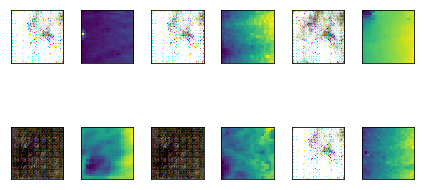

epoch = 932/1000, d_loss=0.179, g_loss=11.015                                                                                                                      
epoch = 933/1000, d_loss=0.163, g_loss=0.110                                                                                                                      
epoch = 934/1000, d_loss=0.170, g_loss=0.094                                                                                                                      
epoch = 935/1000, d_loss=0.163, g_loss=0.093                                                                                                                      
epoch = 936/1000, d_loss=0.163, g_loss=0.095                                                                                                                      
epoch = 937/1000, d_loss=0.163, g_loss=0.096                                                                                                                      
epoch = 938/1000, d_l

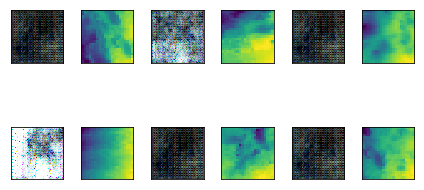

epoch = 942/1000, d_loss=0.163, g_loss=0.087                                                                                                                      
epoch = 943/1000, d_loss=0.163, g_loss=0.085                                                                                                                      
epoch = 944/1000, d_loss=0.163, g_loss=0.084                                                                                                                      
epoch = 945/1000, d_loss=0.163, g_loss=0.082                                                                                                                      
epoch = 946/1000, d_loss=0.163, g_loss=0.082                                                                                                                      
epoch = 947/1000, d_loss=0.163, g_loss=0.145                                                                                                                      
epoch = 948/1000, d_lo

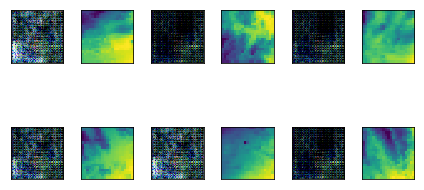

epoch = 952/1000, d_loss=0.163, g_loss=0.078                                                                                                                      
epoch = 953/1000, d_loss=0.163, g_loss=0.084                                                                                                                      
epoch = 954/1000, d_loss=0.163, g_loss=0.078                                                                                                                      
epoch = 955/1000, d_loss=0.163, g_loss=0.087                                                                                                                      
epoch = 956/1000, d_loss=0.163, g_loss=0.082                                                                                                                      
epoch = 957/1000, d_loss=0.163, g_loss=0.078                                                                                                                      
epoch = 958/1000, d_lo

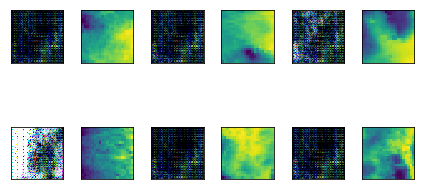

epoch = 962/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 963/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 964/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 965/1000, d_loss=0.163, g_loss=16.118                                                                                                                      
epoch = 966/1000, d_loss=0.163, g_loss=0.094                                                                                                                       
epoch = 967/1000, d_loss=0.163, g_loss=0.099                                                                                                                      
epoch = 968/1000,

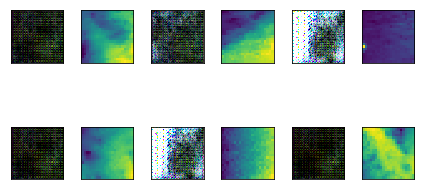

epoch = 972/1000, d_loss=0.163, g_loss=0.091                                                                                                                      
epoch = 973/1000, d_loss=0.163, g_loss=0.090                                                                                                                      
epoch = 974/1000, d_loss=0.163, g_loss=0.089                                                                                                                      
epoch = 975/1000, d_loss=0.163, g_loss=0.089                                                                                                                      
epoch = 976/1000, d_loss=0.163, g_loss=0.088                                                                                                                      
epoch = 977/1000, d_loss=0.163, g_loss=0.087                                                                                                                      
epoch = 978/1000, d_lo

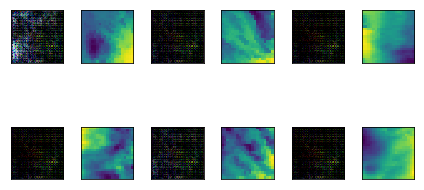

epoch = 982/1000, d_loss=0.163, g_loss=0.088                                                                                                                      
epoch = 983/1000, d_loss=0.163, g_loss=0.082                                                                                                                      
epoch = 984/1000, d_loss=0.163, g_loss=0.083                                                                                                                      
epoch = 985/1000, d_loss=0.163, g_loss=0.083                                                                                                                      
epoch = 986/1000, d_loss=0.163, g_loss=0.083                                                                                                                      
epoch = 987/1000, d_loss=0.163, g_loss=0.081                                                                                                                      
epoch = 988/1000, d_lo

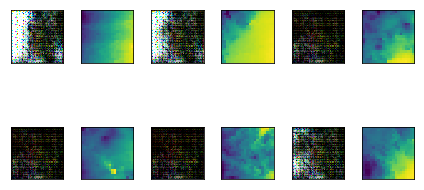

epoch = 992/1000, d_loss=0.163, g_loss=0.080                                                                                                                      
epoch = 993/1000, d_loss=0.163, g_loss=0.079                                                                                                                      
epoch = 994/1000, d_loss=0.163, g_loss=0.078                                                                                                                      
epoch = 995/1000, d_loss=0.163, g_loss=0.077                                                                                                                      
epoch = 996/1000, d_loss=0.163, g_loss=0.076                                                                                                                      
epoch = 997/1000, d_loss=0.163, g_loss=0.077                                                                                                                      
epoch = 998/1000, d_lo

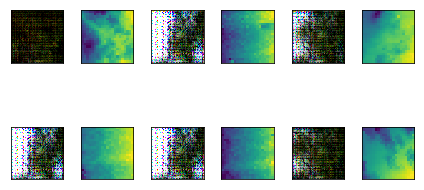

In [28]:
epochs = 1000
batch_size = 32
smooth = 0.1
latent_dim = 100

# adversarial ground-truths
real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(Ximg_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = Ximg_train[i*batch_size:(i+1)*batch_size]
        #real_labels = to_categorical(y_train[i*batch_size:(i+1)*batch_size].reshape(-1, 1), num_classes=10)
        bpatch_batch = Xbathy_train[i*batch_size:(i+1)*batch_size]
        
        
        d_loss_real = discriminator.train_on_batch(x=[X_batch, bpatch_batch],
                                                   y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        
        
        X_fake = generator.predict_on_batch([z, bpatch_batch])
        
        d_loss_fake = discriminator.train_on_batch(x=[X_fake, bpatch_batch], y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        
        # this is selecting random patches from within training set - ideally it would be from all the bathymetry
        
        idx = np.random.randint(0, Xbathy_train.shape[0], batch_size)
        random_bathy = Xbathy_train[idx]
        
        d_g_loss_batch = d_g.train_on_batch(x=[z, random_bathy], y=real)
   
        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(Ximg_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 6
        z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        idx = np.random.randint(0, Xbathy_train.shape[0], samples)
        random_bathy = Xbathy_train[idx]
        
        
        x_fake = generator.predict([z, random_bathy])
        #x_fake = np.clip(x_fake, -1, 1)
        #x_fake = (x_fake + 1) * 127
        x_fake = np.clip(x_fake, 0, 1)
        x_fake = x_fake * 255
        x_fake = np.round(x_fake).astype('uint8')

        for k in range(samples):
            plt.subplot(2, 6, 2*k + 1, xticks=[], yticks=[])
            plt.imshow(x_fake[k])
            plt.subplot(2,6, 2*k + 2, xticks=[], yticks=[])
            plt.imshow(random_bathy[k,:,:,0])

        plt.tight_layout()
        plt.show()

### 5. Evaluate model

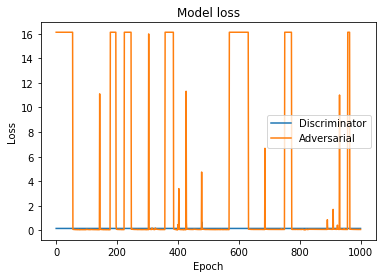

In [29]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

## References

* [Conditional Generative Adversarial Nets](https://arxiv.org/pdf/1411.1784.pdf)
* [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)
* [The CIFAR-10 dataset](https://www.cs.toronto.edu/%7Ekriz/cifar.html)
* [Keras-GAN](https://github.com/eriklindernoren/Keras-GAN)